<a href="https://colab.research.google.com/github/nurdanay/examples/blob/master/Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please add a text block below and enter your name and some information about the file you are working with (language, number of lines and tokens)**:
Nurdan AY
---



# Gensim Word2Vec Tutorial on Horizons Corpus in English data

## Word vectors
Relations captured by word2vec.

<img src="https://miro.medium.com/max/3496/1*jpnKO5X0Ii8PVdQYFO2z1Q.png" alt="drawing" width="400"/> 





## Brief explanation:
This tutorial focuses on the use of the Word2Vec package from the Gensim library.

Word2Vec was introduced in two [papers](#Material-for-more-in-depths-understanding:) in 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by [Gensim](https://radimrehurek.com/gensim/index.html). 

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.<br>

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

# Getting Started

Here you can find more information on the libraries that will be used in the tutorial:
 * pandas: https://pandas.pydata.org/
 * gensim: https://radimrehurek.com/gensim/install.html
 * gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html
 * xlrd: https://pypi.org/project/xlrd/
 * spaCy: https://spacy.io/usage/
 * scikit-learn: http://scikit-learn.org/stable/install.html
 * seaborn: https://seaborn.pydata.org/installing.html
 
 
 
 Now import the libraries.

In [0]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# The data: Horizons Corpus in English


Horizons shines a light on scientific research in Switzerland. The magazine reports on the latest developments in the science world and discusses research policy issues of global importance.

Horizons is published by the Swiss National Science Foundation and the Swiss Academies of Arts and Sciences. The editors are independent and the articles do not necessarily reflect the opinions of the publishers.

A print edition of Horizons is published four times a year in German and French. The online version is also available in English.
 



 






# Preprocessing



Make a copy of this tutorial to your google drive. Rename it. 

Choose a corpus file for a particular language from the **material/exercise6** folder on r2d2. Convert it to one-sentence-per-line format as instructed in the assignment. Then download it from the server onto your machine.

Now you need to upload the file here. In the menu on the left, under **Files** click on **Upload** and select the file from your computer. This can take a while depending on your internet speed and size of your file...

Once the file is uploaded you can read it into a pandas dataframe using the command below. (A pandas dataframe is a table-like object useful for data analytics in Python)

In [9]:
df = pd.read_csv('big_data.csv', engine='python', encoding='utf8', error_bad_lines=False)
df.shape

(21024, 1)

In [10]:
df.head()

,Sentences
0,Let 's not fan the flames
1,In 1929 - the year of the crash on Wall Street...
2,The growing disapproval of the public soon led...
3,Even psychologists helped improve pilot traini...
4,"Nearly 90 years later , the rate of fatal avia..."


Removing the missing values:

In [11]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

Sentences    0
dtype: int64

Depending on the language you have decided to work on, modify the language code in the next two commands accordingly in order to work with the correct spacy language package.

In [12]:
# installing the language package.
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')



Here, we create a function that will lemmatize and remove stopwords (a.k.a. non-content words) for each line of corpus.

In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop] 
 
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

We remove non-alphabetic characters but we make sure to keep all the non-ascii characters specific to our languages! For more information take a look at this table of unicode characters:
https://unicode-table.com/en/#control-character

**Achtung**: if you are working with German, remove the .lower() method from the command below. We want to keep those nouns capitalized.

In [0]:
brief_cleaning = (re.sub("[^\u00C0-\u017FA-Za-z']+", ' ', str(row)).lower() for row in df['Sentences'])

Now we put all the steps together and clean the corpus. It can be a long process so we use spaCy's .pipe() attribute to speed it up. However for the entire German corpus of 23 million tokens it might still take up to 20 mins and more!

In [15]:
t = time()
print(nlp.pipe_names)

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

['tagger']
Time to clean up everything: 0.26 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [16]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(16250, 1)

In [17]:
df_clean.head()

,clean
0,let fan flame
1,year crash wall street aircraft accident kill ...
2,grow disapproval public soon lead safe fly man...
3,psychologist help improve pilot training intro...
4,nearly year later rate fatal aviation accident...


## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "new_york".

In [0]:
from gensim.models.phrases import Phrases, Phraser

`Phrases()` takes a list of lists of words as input:

In [0]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [21]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 07:48:05: collecting all words and their counts
INFO - 07:48:05: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 07:48:05: PROGRESS: at sentence #10000, processed 89058 words and 77227 word types
INFO - 07:48:05: collected 117574 word types from a corpus of 143717 words (unigram + bigrams) and 16250 sentences
INFO - 07:48:05: using 117574 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [22]:
bigram = Phraser(phrases)

INFO - 07:52:50: source_vocab length 117574
INFO - 07:52:51: Phraser built with 25 phrasegrams


Transform the corpus based on the bigrams detected:

In [0]:
sentences = bigram[sent]

## Most Frequent Words:
Let's take a closer look at our data by making a dictionary of the most frequent words in our courpus. This helps us control the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams. If you are working with French, uncomment the length restriction on words in order to avoid the pleintuful French contractions.

In [24]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
      # if len(i)>1:
        word_freq[i] += 1
len(word_freq)

14429

In [25]:
# print 20 most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

["'",
 'research',
 'say',
 'researcher',
 'science',
 'new',
 'people',
 'university',
 'work',
 'time',
 'year',
 'study',
 'swiss',
 'switzerland',
 'find',
 'different',
 'example',
 'project',
 'result',
 'world']

# Training the model
## Gensim Word2Vec Implementation:

In [0]:
import multiprocessing

from gensim.models import Word2Vec

## Training of the model often happens in 3 steps:
1. `Word2Vec()`: 
In this first step, we set up the parameters of the model one-by-one. 
2. `.build_vocab()`: 
Here it builds the vocabulary from a sequence of sentences and thus initializes the model. 
3. `.train()`:
Finally, we train the model.

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [0]:
# count the number of cores in a computer
cores = multiprocessing.cpu_count() 

In [0]:
# pass the parameters to the model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [29]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 07:56:07: collecting all words and their counts
INFO - 07:56:07: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 07:56:08: PROGRESS: at sentence #10000, processed 88228 words, keeping 11201 word types
INFO - 07:56:08: collected 14429 word types from a corpus of 142340 raw words and 16250 sentences
INFO - 07:56:08: Loading a fresh vocabulary
INFO - 07:56:08: effective_min_count=20 retains 1474 unique words (10% of original 14429, drops 12955)
INFO - 07:56:08: effective_min_count=20 leaves 99672 word corpus (70% of original 142340, drops 42668)
INFO - 07:56:08: deleting the raw counts dictionary of 14429 items
INFO - 07:56:08: sample=6e-05 downsamples 1474 most-common words
INFO - 07:56:08: downsampling leaves estimated 35716 word corpus (35.8% of prior 99672)
INFO - 07:56:08: estimated required memory for 1474 words and 300 dimensions: 4274600 bytes
INFO - 07:56:08: resetting layer weights


Time to build vocab: 0.02 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

The training may take some time as well. For the full German corpus, for example, it can last up to 45 mins.

In [30]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 07:56:16: training model with 1 workers on 1474 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 07:56:16: worker thread finished; awaiting finish of 0 more threads
INFO - 07:56:16: EPOCH - 1 : training on 142340 raw words (35957 effective words) took 0.7s, 52564 effective words/s
INFO - 07:56:17: worker thread finished; awaiting finish of 0 more threads
INFO - 07:56:17: EPOCH - 2 : training on 142340 raw words (35667 effective words) took 0.7s, 52174 effective words/s
INFO - 07:56:18: worker thread finished; awaiting finish of 0 more threads
INFO - 07:56:18: EPOCH - 3 : training on 142340 raw words (35706 effective words) took 0.7s, 50704 effective words/s
INFO - 07:56:19: worker thread finished; awaiting finish of 0 more threads
INFO - 07:56:19: EPOCH - 4 : training on 142340 raw words (35734 effective words) took 0.7s, 51357 effective words/s
INFO - 07:56:19: worker thread finished; awaiting finish of 0 more threads
INFO - 07:56:19: EPOCH 

Time to train the model: 0.36 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [31]:
w2v_model.init_sims(replace=True)

INFO - 08:03:19: precomputing L2-norms of word weight vectors


# Exploring the model

**Note:** if any of the example words are not in the vocabulary of your dataset, choose different words. If you are working with German or French, replace the example words with their equivalents in your chosen language.
## Task 1: Find the most similar

Here, we will ask our model to find the words most similar to some of the words in the corpus! 

In [0]:
w2v_model.wv.most_similar(positive=["research"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('project', 0.1162150651216507),
 ('bee', 0.11204305291175842),
 ('park', 0.10816352814435959),
 ('set', 0.09712697565555573),
 ('year', 0.058459386229515076),
 ('work', 0.05784310773015022),
 ('science', 0.05644134059548378),
 ('water', 0.05238720402121544),
 ('study', 0.04934116452932358),
 ('wild', 0.0432223342359066)]

In [32]:
w2v_model.wv.most_similar(positive=["virus"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bacteria', 0.9997088313102722),
 ('antibody', 0.999688982963562),
 ('blood', 0.9996790289878845),
 ('pathogen', 0.9996466040611267),
 ('genetic_material', 0.9996213912963867),
 ('immune_system', 0.9996191263198853),
 ('genetic', 0.9996169805526733),
 ('disease', 0.9996041655540466),
 ('occur', 0.999595582485199),
 ('alter', 0.9995887279510498)]

This next word is the same in all three languages except that you have to capitalize it if you are working with German.


In [40]:
w2v_model.wv.most_similar(positive=["root"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('origin', 0.9997177124023438),
 ('source', 0.9997109770774841),
 ('survive', 0.999699592590332),
 ('discover', 0.9996928572654724),
 ('object', 0.9996925592422485),
 ('ground', 0.9996883869171143),
 ('compare', 0.9996861815452576),
 ('lose', 0.9996842741966248),
 ('island', 0.9996826648712158),
 ('drive', 0.9996800422668457)]

<img src=https://cdn2.iconfinder.com/data/icons/adventure-24/249/adventure-adventurer-explore-explorer-005-512.png width="50"> Add a code block below and search for some other word of your interest. If the word is not in the vocabulary, try a different one. What do you think about the most similar words? Do they all make sense? Try to explain your reasoning.

## Taks2: Similarity between two words
Here, we will see how similar two words are to each other :

In [39]:
w2v_model.wv.similarity("science", 'biology')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99798644

<img src=https://cdn2.iconfinder.com/data/icons/adventure-24/249/adventure-adventurer-explore-explorer-005-512.png width="50"> Choose two more words and find how similar they are. Try to find an interesting example. Does the similarity value surprise you or conform to your expectations?  

In [43]:
w2v_model.wv.similarity('economy', 'resource')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9995702

## Task 3: Odd-One-Out

Here, we ask our model to give us the word that does not belong to the list! Do you agree with the model?

In [44]:
w2v_model.wv.doesnt_match(['risk', 'crisis', 'financial'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'risk'

In [53]:
w2v_model.wv.doesnt_match(['history', 'epic', 'traditional'])

WARNING - 08:25:05: vectors for words {'epic'} are not present in the model, ignoring these words
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'traditional'

## Task 4: Analogy difference or vector math
You have probably seen the classic example that demonstrates the power of word embeddings:

**king - man + woman = queen**

The little illustration at the very beginning of this tutorial shows what this relation looks like in vector space. In other words: which word is to *woman* as *king* is to *man*?
Let's try to reproduce this example with our corpus. Does it work? 

In [52]:
w2v_model.wv.most_similar(positive=["universe", "galaxy"], negative=["unknown"], topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hole', 0.9992321133613586),
 ('box', 0.9989795088768005),
 ('sun', 0.9989705085754395)]

<img src=https://cdn2.iconfinder.com/data/icons/adventure-24/249/adventure-adventurer-explore-explorer-005-512.png width="50"> Can you find a different example of such a relation? Add another code block and try!

In [55]:
w2v_model.wv.most_similar(positive=["engineering", "lab"], negative=["genetic"], topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('institute', 0.9993104934692383),
 ('art', 0.999159574508667),
 ('university_zurich', 0.999120831489563)]

# Visualisation with t-SNE
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [0]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    ### Anastassia's COMMENT: The intial value for n_components=50 didn't work!
    ### ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=19 with svd_solver='full'
    ### replaced 50 with 19
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

## Task 5: 10 Most similar words vs. 8 Random words
Let's compare where the vector representation of 'mountain', its 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph. The most similar words will be used automatically. You are free to change the list of random words based on your interest and the dataset's vocabulary.

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


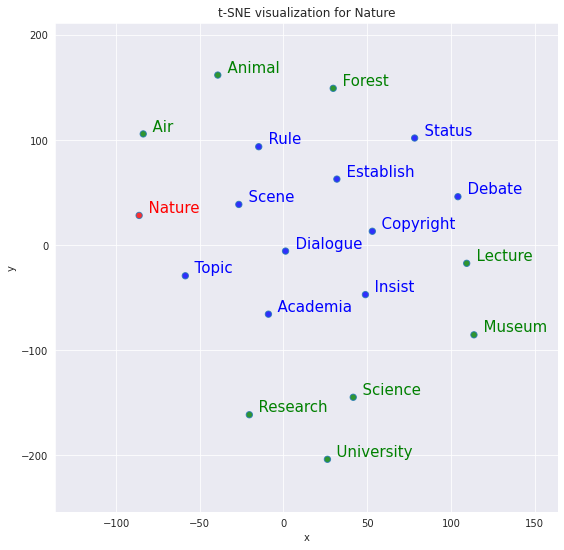

In [59]:
tsnescatterplot(w2v_model, 'nature', ['science', 'forest', 'animal', 'university', 'museum', 'air', 'research', 'lecture'])

Interestingly, the 10 most similar words to 'mountain' end up around it, so do some of other random words. Does it make sense?

## Task 6: 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of 'Switzerland' and its 10 most similar words from the model lies compared to the vector representation of the 10 most dissimilar words to 'Switzerland':

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


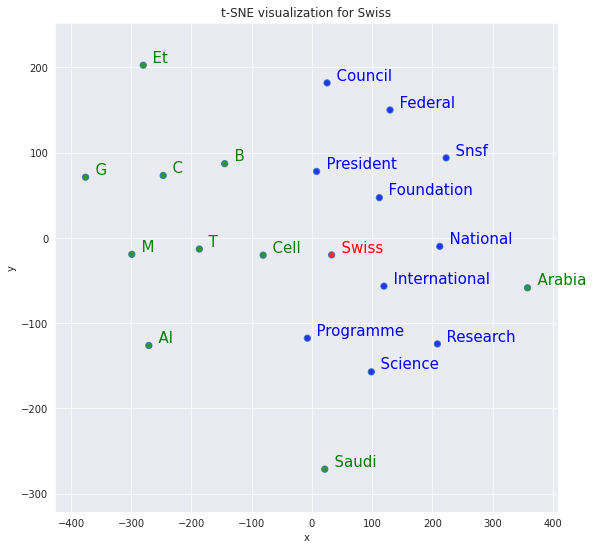

In [60]:
tsnescatterplot(w2v_model, 'swiss', [i[0] for i in w2v_model.wv.most_similar(negative=["swiss"])])

## Task 7: 

<img src=https://cdn2.iconfinder.com/data/icons/adventure-24/249/adventure-adventurer-explore-explorer-005-512.png width="50"> Find your own examples for tasks 5 and 6. Add code blocks and create plots. 




# Materials for more in depths understanding:
* Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
* Word2Vec introduction: https://skymind.ai/wiki/word2vec
* Another Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* A great Gensim implentation tutorial: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x
* Original articles from Mikolov et al.: https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546


# References:
* Text+Berg info: http://textberg.ch/site/de/korpora/
* The original tutorial is here: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
* Aneesha Bakharia Medium article: https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

# THE END